In [21]:
import numpy as np
import matplotlib.pyplot as plt
plt.rc("font", family=["Helvetica", "Arial"]) # skifter skrifttype
plt.rc("axes", labelsize=22)   # skriftstørrelse af `xlabel` og `ylabel`
plt.rc("xtick", labelsize=22, top=True, direction="out")
plt.rc("ytick", labelsize=22, right=True, direction="out")
plt.rc("axes", titlesize=22)
plt.rc("legend", fontsize=20)

In [64]:
def getNormalized(filepath):
    data = np.loadtxt(filepath, skiprows=1)
    return (data[2:, 0], (data[2:,1]-data[0,0])/data[1, 1])
# def combineRandT(file1, file2):
#     data1 = np.loadtxt(file1, skiprows=8)
#     data2 = np.loadtxt(file2, skiprows=8)
#     return (data1[1:, 0], data1[1:,1]/data1[0, 1] + data2[1:,1]/data2[0, 1]) #Assuming measured @ the same theta_1
def Rp(t1, t2):
    return np.tan(t1-t2)**2/np.tan(t1+t2)**2
def Tp(t1, t2):
    return 1-Rp(t1, t2)
def Rs(t1, t2):
    return np.sin(t1-t2)**2/(np.sin(t1+t2))**2
def Ts(t1, t2):
    return 1-Rs(t1, t2)
def getTheo(t1, t2, pol):
    if pol is "s":
        return (Ts(t1, t2), Rs(t1, t2))
    elif pol is "p":
        return (Tp(t1, t2), Rp(t1, t2))

def td_to_t2(t1, td, isPrime): #Prime or not depends on whether the detector angles starts from 180 or not
    if not isPrime:
        td = 180-td
    return t1-td

<ErrorbarContainer object of 3 artists>

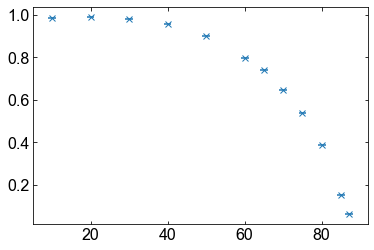

In [65]:
plt.errorbar(*getNormalized("finalized_data/a-g s trans.txt"), xerr=1, fmt='x')

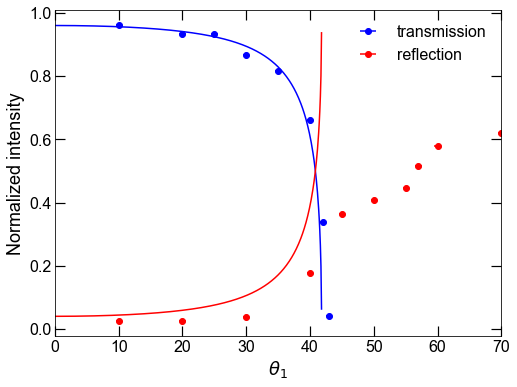

In [91]:
direction = "g-a"
polarization = "s"
n_air = 1
n_glass = 1.5 # to be found

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(8, 6)

if direction == "a-g":
    n_1 = n_air
    n_2 = n_glass
    ax.set_xlim(0, 90)
else:
    n_1 = n_glass
    n_2 = n_air
    ax.set_xlim(0, 70)

theta_1s = np.linspace(0, np.pi/2, 1000)
theta_2s = np.arcsin(n_1*np.sin(theta_1s)/n_2)
theo_T, theo_R = getTheo(theta_1s, theta_2s, polarization)

ax.plot(theta_1s*180/np.pi, theo_T, 'b')
ax.plot(theta_1s*180/np.pi, theo_R, 'r')

trans = getNormalized("finalized_data/"+ direction +" "+ polarization + " trans.txt")
refl = getNormalized("finalized_data/"+ direction +" "+ polarization + " refl.txt")

# NB: theo_T[1] scaling to accomodate for the fact that I(0) is NOT the max - and a weird parameter to normalize with
ax.errorbar(trans[0], trans[1]*theo_T[1], xerr=0.5, fmt='bo', label="transmission") 
# Perhaps do similar scaling for reflected light
ax.errorbar(refl[0], refl[1], xerr=0.5, fmt='ro', label="reflection")
# plt.title("g-a s")


ax.set_xlabel("$\\theta_1$")
ax.set_ylabel("Normalized intensity")
ax.legend(frameon=False)
plt.tick_params(which='major', axis='both', length=10, width=1.2)
plt.tick_params(which='minor', axis='both', length=6, width=1.2)

# plt.savefig("prelim_figs/"+direction +" "+ polarization + ".png", dpi=200)

In [16]:
#Calculate t2 and fit for n2

0.9599997033173505